### Forecasting Wind Turbine Power Output

#### Week 1

##### Data
The Wind Turbine Scada Dataset (year 2018).



In [2]:
# Importing Dataset
import pandas as pd
turbine_data = pd.read_csv('WindTurbine_Data.csv')
turbine_data.head(10)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


##### Preprocessing

In [3]:
turbine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
# Find and remove Null values
turbine_data.isnull().sum()

,0
Date/Time,0
LV ActivePower (kW),0
Wind Speed (m/s),0
Theoretical_Power_Curve (KWh),0
Wind Direction (°),0


In [5]:
# Duplicate values
turbine_data.duplicated().sum()

np.int64(0)

In [6]:
# Converting Date/time same format.
turbine_data['Date/Time'] = pd.to_datetime(turbine_data['Date/Time'], format='%d %m %Y %H:%M')
# keeping it time ordered
turbine_data = turbine_data.sort_values(by='Date/Time')

display(turbine_data.head())

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


##### Feature Engineering

In [7]:
# wind speed cubed
turbine_data['Wind_Speed_Cubed'] = turbine_data['Wind Speed (m/s)'] ** 3  # Physics: P ∝ v³

#Dir_Sin & Dir_Cos for 0 to 360 degree to radinas
import numpy as np
turbine_data['Dir_Sin'] = np.sin(np.deg2rad(turbine_data['Wind Direction (°)']))
turbine_data['Dir_Cos'] = np.cos(np.deg2rad(turbine_data['Wind Direction (°)']))

#Rolling spreed to smooth guts
turbine_data['Rolling_Speed'] = turbine_data['Wind Speed (m/s)'].rolling(window=3, min_periods=1, center=True).mean()

#Theoretical_kW: Unit fix (kWh *6 for 10-min → kW)
turbine_data['Theoretical_kW'] = turbine_data['Theoretical_Power_Curve (KWh)'] * 6

#Deficit & Efficiency: Post-pred diagnostics (add now for EDA)
turbine_data['Power_Deficit'] = turbine_data['Theoretical_kW'] - turbine_data['LV ActivePower (kW)']
turbine_data['Efficiency (%)'] = (turbine_data['LV ActivePower (kW)'] / turbine_data['Theoretical_kW']) * 100
turbine_data['Efficiency (%)'] = turbine_data['Efficiency (%)'].clip(0, 100)  # Bound

print(turbine_data[['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Dir_Sin', 'Dir_Cos', 'Rolling_Speed', 'Theoretical_kW', 'Power_Deficit', 'Efficiency (%)']].head())
# Save: turbine_data.to_csv('New_turbine_data.csv', index=False)


   Wind Speed (m/s)  Wind_Speed_Cubed   Dir_Sin   Dir_Cos  Rolling_Speed  \
0          5.311336        149.834333 -0.984792 -0.173736       5.491751   
1          5.672167        182.493326 -0.999719 -0.023715       5.399847   
2          5.216037        141.912921 -0.998998  0.044749       5.515959   
3          5.659674        181.290183 -0.999759  0.021956       5.484551   
4          5.577941        173.548848 -0.997151 -0.075426       5.613889   

   Theoretical_kW  Power_Deficit  Efficiency (%)  
0     2497.973447    2117.925656       15.214245  
1     3119.505067    2665.735871       14.546192  
2     2345.400095    2039.023508       13.062871  
3     3096.765414    2677.119509       13.551104  
4     2950.217832    2569.567136       12.902461  


##### EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np

sns.set_style("whitegrid") #clean white bg
plt.rcParams['figure.figsize'] = (12,6) # rcParams runtime configuration to cntrl dfult plot settings
%matplotlib inline

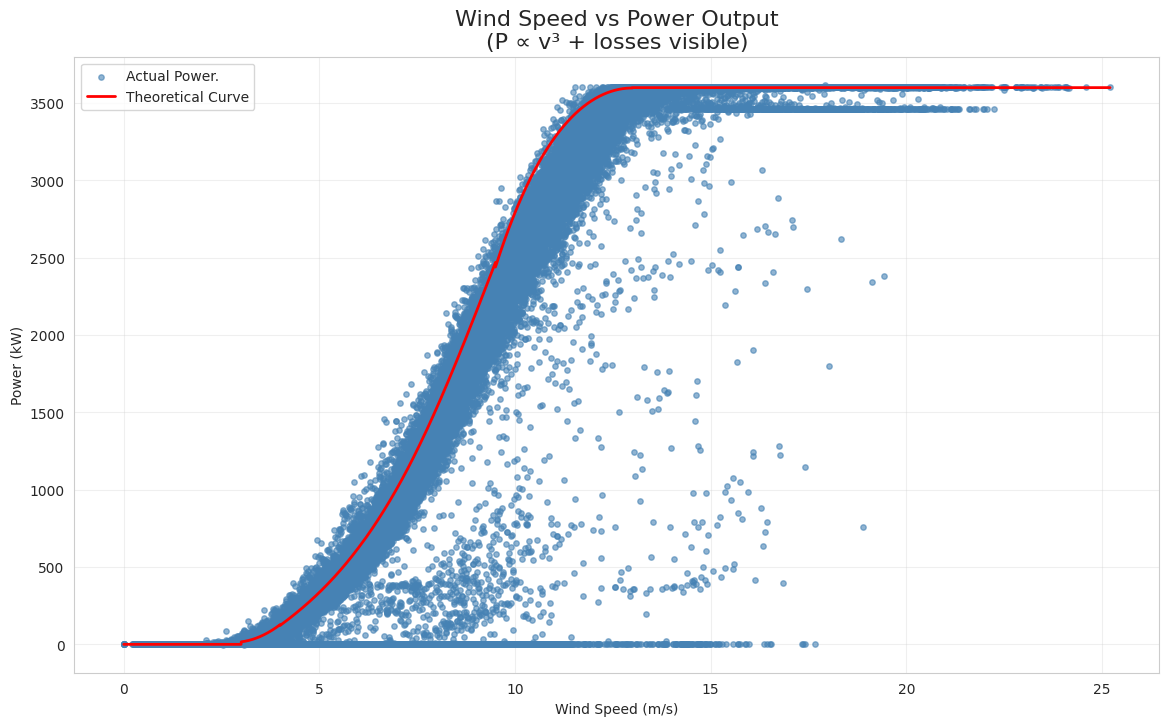

In [19]:
# plot1 Wind speed Vs power (scatter plot)
plt.figure(figsize=(14,8))
plt.scatter(turbine_data['Wind Speed (m/s)'],  turbine_data['LV ActivePower (kW)'], alpha=0.6, s=15, color='steelblue', label="Actual Power.")
theo = turbine_data.sort_values('Wind Speed (m/s)')
plt.plot(theo['Wind Speed (m/s)'], theo['Theoretical_Power_Curve (KWh)'],
         color='red', linewidth=2, label='Theoretical Curve')

plt.title('Wind Speed vs Power Output\n(P ∝ v³ + losses visible)', fontsize=16)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3) # .3 transperancy or visiblity
plt.show()

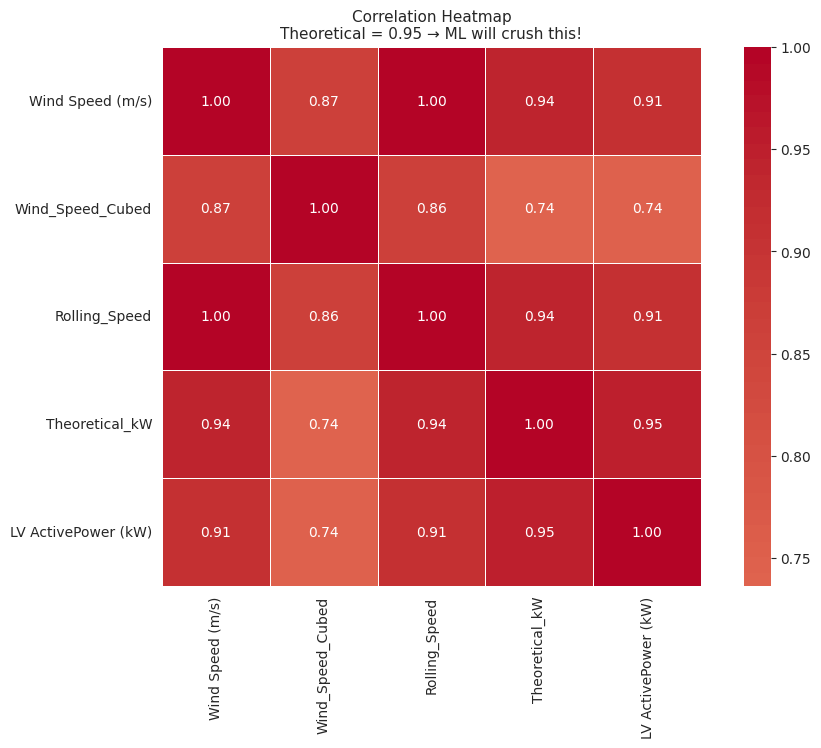

In [35]:
corr = turbine_data[['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Rolling_Speed','Theoretical_kW', 'LV ActivePower (kW)']].corr()

plt.figure(figsize=(11, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap\nTheoretical = 0.95 → ML will crush this!', fontsize=11)
plt.show()

/tmp/ipython-input-1028252819.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zones = turbine_data.groupby('Zone').agg({'LV ActivePower (kW)': 'mean','Date/Time': 'count'}).round(0)


,LV ActivePower (kW),Date/Time,% Time,% Energy
Zone,,,,
Low (<5 m/s),50.0,15744,31.2,1.2
Med (5-10 m/s),1082.0,21183,41.9,34.7
High (>10 m/s),3114.0,13603,26.9,64.1


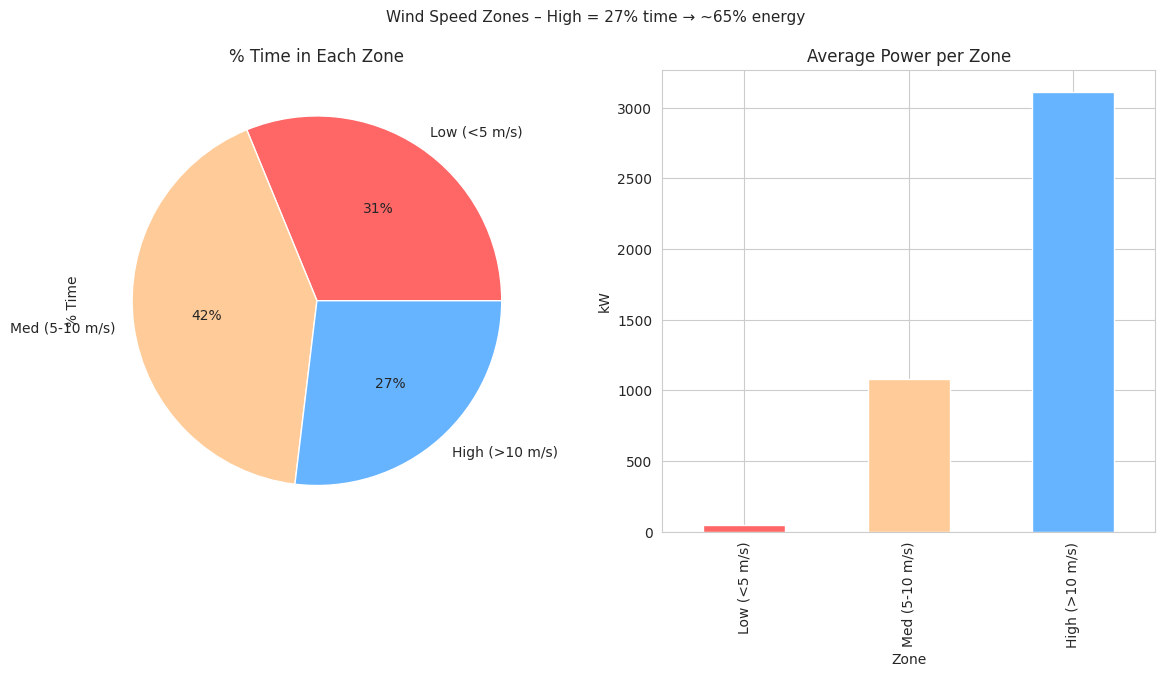

In [43]:
# plot3 Zones(bar+pie)+table
#create zones
bins = [-float('inf'), 5, 10, float('inf')]                # edges: -∞ to 5, 5 to 10, 10 to ∞
labels = ['Low (<5 m/s)', 'Med (5-10 m/s)', 'High (>10 m/s)']
turbine_data['Zone'] = pd.cut(turbine_data['Wind Speed (m/s)'],
                    bins=bins,
                    labels=labels,
                    include_lowest=True)
turbine_data['Zone'].value_counts()

#
zones = turbine_data.groupby('Zone').agg({'LV ActivePower (kW)': 'mean','Date/Time': 'count'}).round(0)

zones['% Time'] = (zones['Date/Time'] / len(turbine_data) * 100).round(1)
zones['% Energy'] = (zones['LV ActivePower (kW)'] * zones['Date/Time'] / turbine_data['LV ActivePower (kW)'].sum() * 100).round(1)
display(zones)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

zones['% Time'].plot.pie(autopct='%1.0f%%', ax=ax1, colors=['#ff6666', '#ffcc99', '#66b3ff'])
ax1.set_title('% Time in Each Zone')

zones['LV ActivePower (kW)'].plot.bar(ax=ax2,color=['#ff6666', '#ffcc99', '#66b3ff'])
ax2.set_title('Average Power per Zone')
ax2.set_ylabel('kW')

plt.suptitle('Wind Speed Zones – High = 27% time → ~65% energy', fontsize=11)
plt.show()